In [79]:
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import torch
import numpy as np
import dask

from project.utils.geo import msc_align, msc2date, stacktime, stackdims
from project.utils.geo_plots import savefig, plot_map

mpl.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.dpi'] = 150

In [2]:
def norm(ds):
    return (ds - ds.attrs['mean']) / ds.attrs['std']

def coords2sample(ds):
    return stackdims(ds, ['lat', 'lon'], 'sample')

In [15]:
static_vars = ['wtd', 'canopyheight', 'percent_tree_cover', 'rootdepth', 'sandfrac', 'topidx']
dynamic_vars = ['t2m', 'ssrd', 'rh_cf', 'tp']

In [4]:
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/').sel(time='2015')
igs = xr.open_zarr('../../experiments/default/exp_00_2023-03-30_16-03-29/tune/trial00/ig.zarr/')

In [5]:
mask = igs.wtd.isel(time=0).drop('time').notnull()

In [6]:
scube = cube[static_vars].where(mask).load()

In [7]:
for var in scube.data_vars:
    scube[var] = norm(scube[var])

In [8]:
fvc = cube['fvc_ano'].sel(time='2015').load()

In [9]:
fvc = fvc.where(mask).compute()

In [10]:
fmask = coords2sample(mask)

In [11]:
fscube = coords2sample(scube).where(fmask, drop=True).compute()

In [12]:
ffvc = coords2sample(fvc).where(fmask, drop=True).compute()

In [13]:
fsigs = coords2sample(igs[static_vars]).where(fmask, drop=True).compute()

In [17]:
fvc_mean = ffvc.mean('time').compute()
fvc_mean_min, fvc_mean_max = fvc_mean.quantile([0.05, 0.95])

# Static covariates

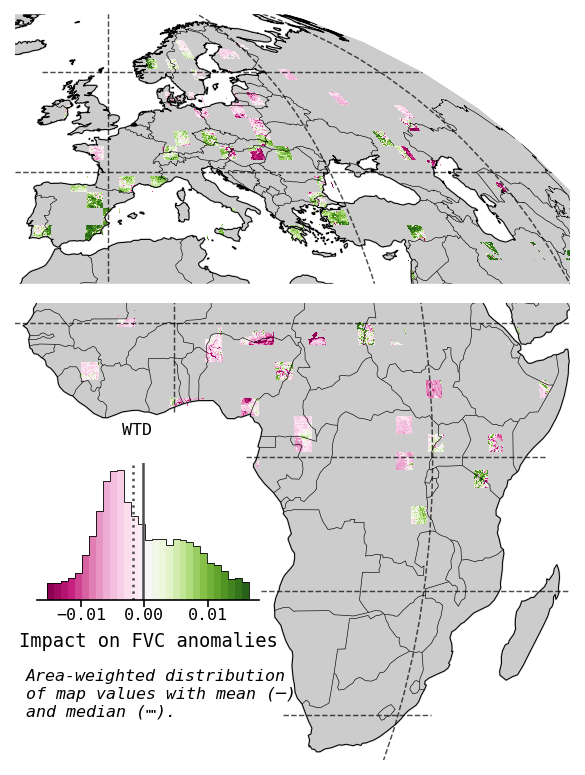

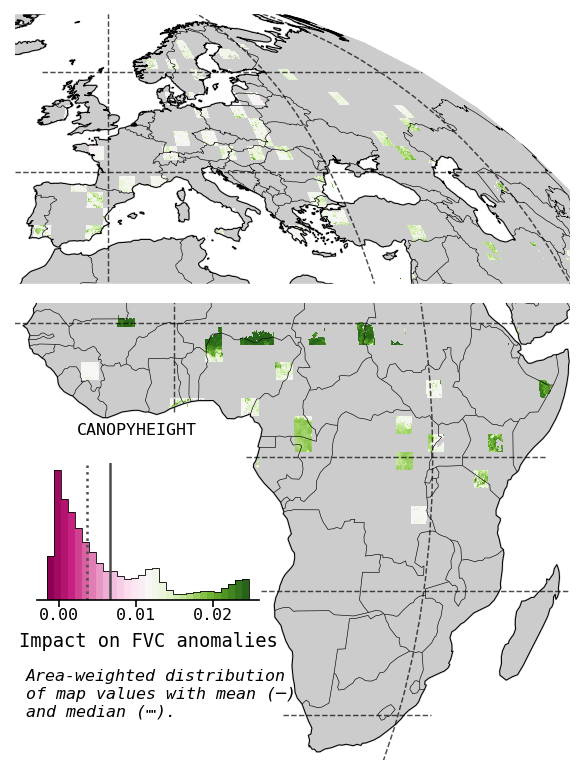

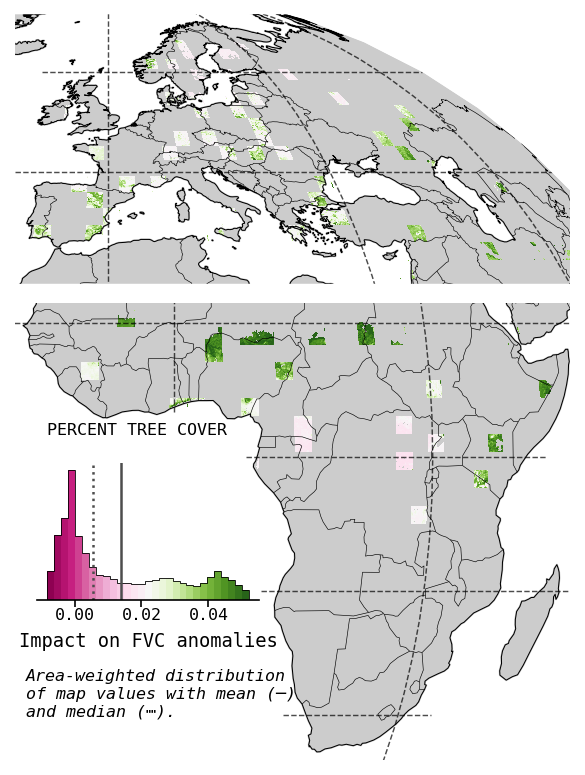

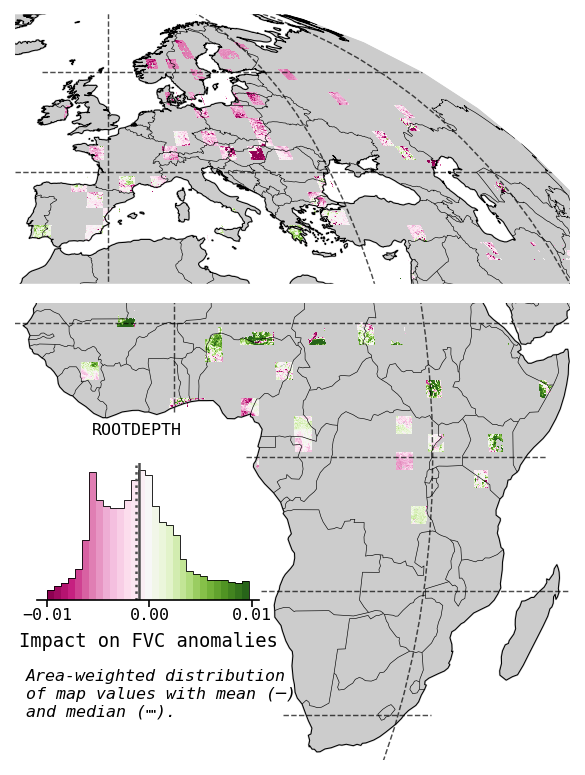

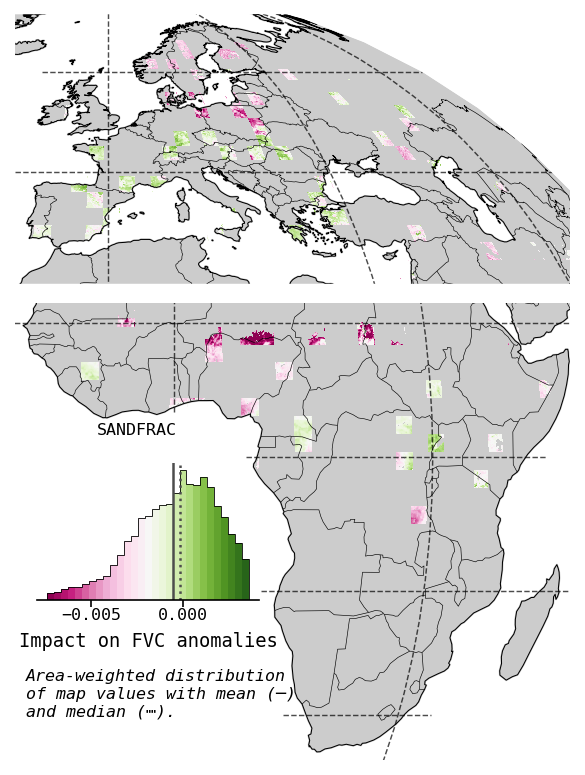

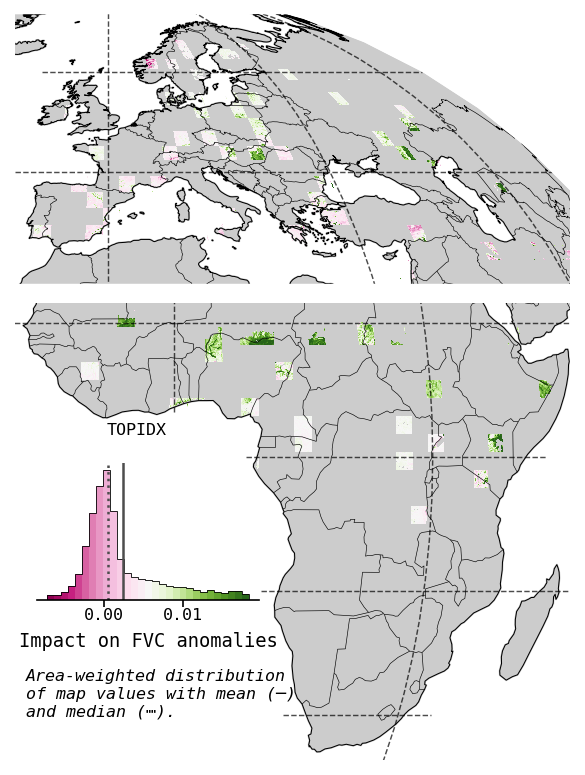

In [111]:
for var in static_vars:
    fig, ax = plot_map(
        igs[var].isel(time=0).load(),
        label='Impact on FVC anomalies',
        title=f'{var.replace("_", " ").upper()}',
        cmap='PiYG',
        robust=True,
        do_center=True
    )

    savefig(fig, path=f'../../visualization/plots/ig_map_{var}.png')

/Net/Groups/BGI/people/bkraft/drought_ml/project/utils/geo_plots.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


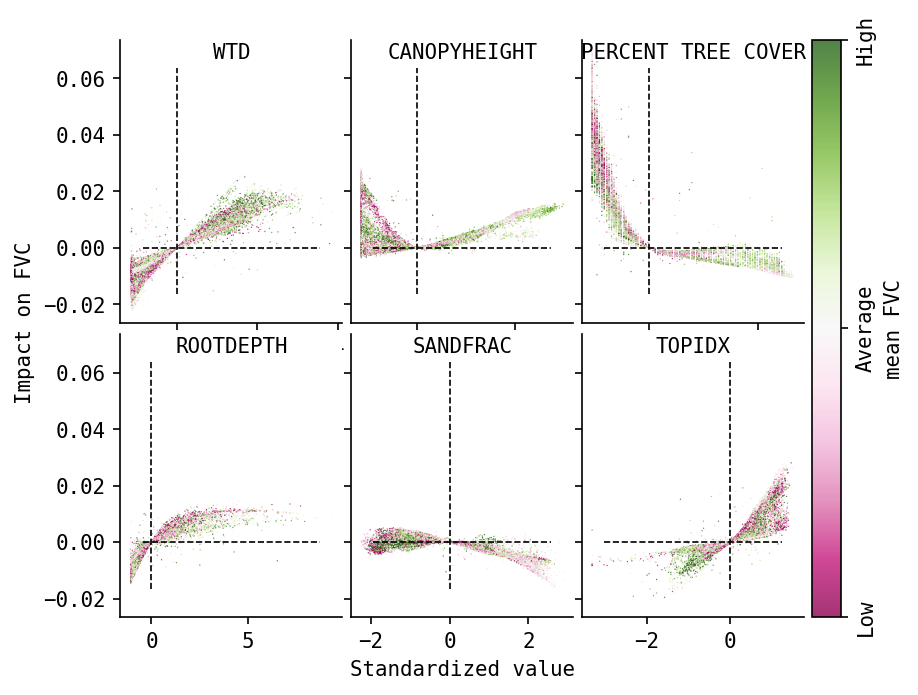

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5), sharey=True, gridspec_kw={'hspace': 0.04, 'wspace': 0.04})

for i, var in enumerate(static_vars):
    ax = axes.flatten()[i]
    im = ax.scatter(fscube[var], fsigs[var].isel(time=0), c=fvc_mean, s=0.4, vmin=fvc_mean_min, vmax=fvc_mean_max, cmap='PiYG', alpha=0.8, edgecolor='none')
    ax.spines[['top', 'right']].set_visible(False)
    ax.text(0.5, 0.99, var.replace('_', ' ').upper(), transform=ax.transAxes, ha='center', va='top')
    ax.axvline(0.0, color='k', lw=0.8, ls='--', ymin=0.1, ymax=0.9)
    ax.axhline(0.0, color='k', lw=0.8, ls='--', xmin=0.1, xmax=0.9)

axes[0, 0].set_ylabel('Impact on FVC', y=0)
axes[1, 1].set_xlabel('Standardized value')

cbar = fig.colorbar(im, ax=axes, ticks=[fvc_mean_min, (fvc_mean_min + fvc_mean_max) / 2, fvc_mean_max], pad=0.01, label='mean FVC')
cbar.ax.set_yticklabels(['Low', 'Average', 'High'], rotation=90, va='center')

savefig(fig, path='../../visualization/plots/static_ig.png', dpi=500)

# Dynamic covariates

In [37]:
r = igs['wtd'].isel(time=0).load()

In [75]:
lons = [-2, 4, 24]
lats = [41, 12, -8]

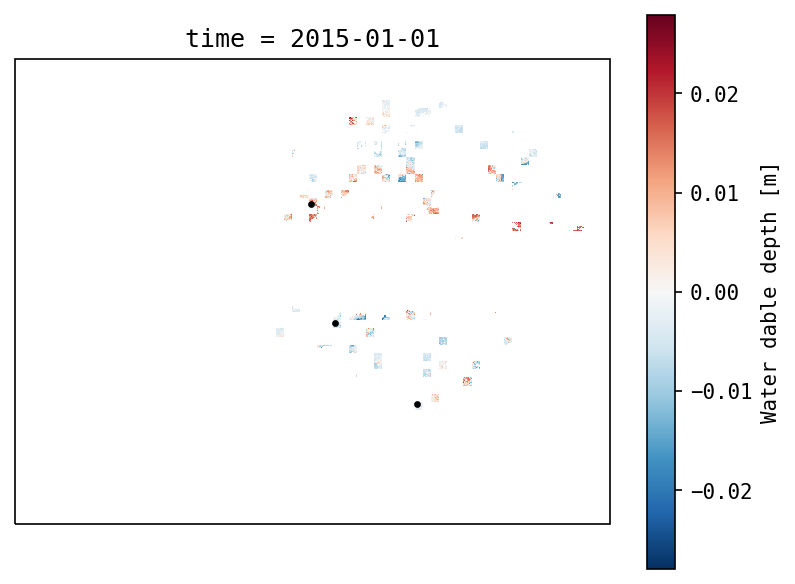

In [76]:
ax = plt.subplot(projection=ccrs.PlateCarree())
r.plot(ax=ax)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=5, color='black')

In [25]:
# .context.expand_dims(time=attr.attr.time).values
x = stackdims(igs.tp, ['context', 'hour'], 'context', False).context.expand_dims(time=igs.time).values

/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/xarray/core/variable.py:1730: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


In [28]:
stackdims(igs.tp, ['context', 'hour'], 'context', False)

/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/xarray/core/variable.py:1730: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


<xarray.DataArray 'tp' (time: 365, lat: 1140, lon: 1460, context: 17520)>
dask.array<reshape, shape=(365, 1140, 1460, 17520), dtype=float32, chunksize=(10, 20, 20, 17520), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
  * context  (context) int64 -17519 -17518 -17517 -17516 -17515 ... -3 -2 -1 0
Attributes:
    long_name:  Total precipitation
    mean:       0.12476687176274043
    std:        0.5033277055413958
    units:      m

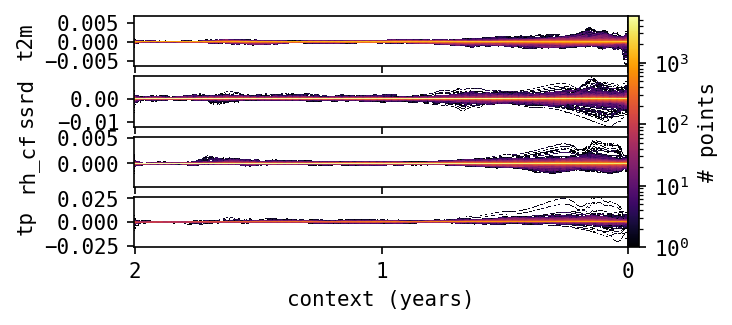

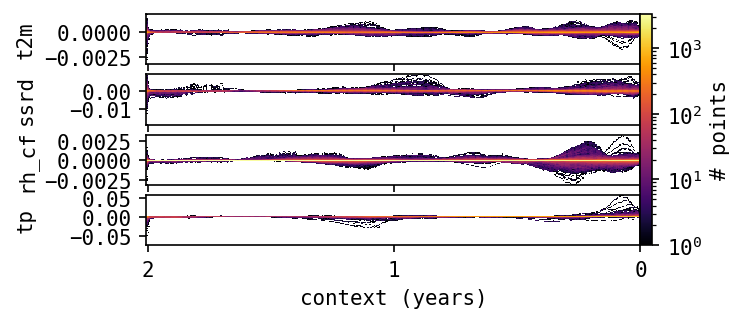

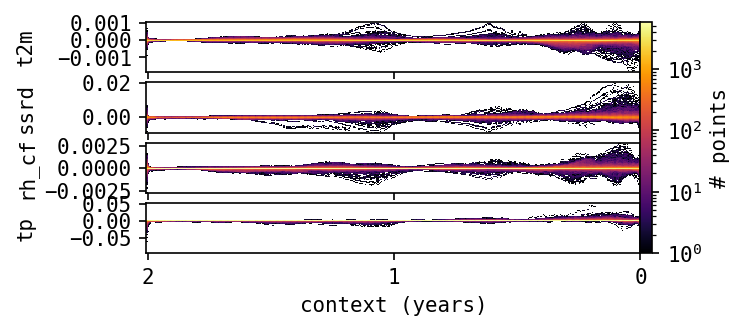

In [90]:
for lat, lon in zip(lats, lons):

    fig, axes = plt.subplots(4, 1, figsize=(5, 2), sharex=True)

    threshold = 0.000

    for i, var in enumerate(dynamic_vars):
        ax = axes[i]
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            s = stackdims(igs[var], ['context', 'hour'], 'context', False)
            x = s.context.expand_dims(time=igs.time).values
            y = s.sel(lat=lat, lon=lon).values


        mask = np.abs(y) > threshold
        x = x[mask]
        y = y[mask]

        h, xedges, yedges = np.histogram2d(
            x,
            y,
            bins=[400, 100]
        )

        pcm = ax.pcolormesh(
            xedges, yedges, h.T, cmap='inferno', rasterized=True, norm=mpl.colors.LogNorm()
        )

        xtick_pos = np.arange(0, -len(s.context), -364 * 24)
        xtick_labels = np.arange(len(xtick_pos))
        ax.set_xticks(xtick_pos, labels=xtick_labels)
        ax.set_xlabel('context (years)')
        ax.set_ylabel(var)

    fig.colorbar(pcm, ax=axes, label="# points", pad=0)

    fig.align_ylabels(axes)

    fig.savefig(f'../../visualization/plots/dynamic_timehist_lat{lat}_lon{lon}.png', dpi=300, bbox_inches='tight')
    # savefig(fig, path=f'../../visualization/plots/dynamic_timehist_lat{lat}_lon{lon}.png', dpi=300)

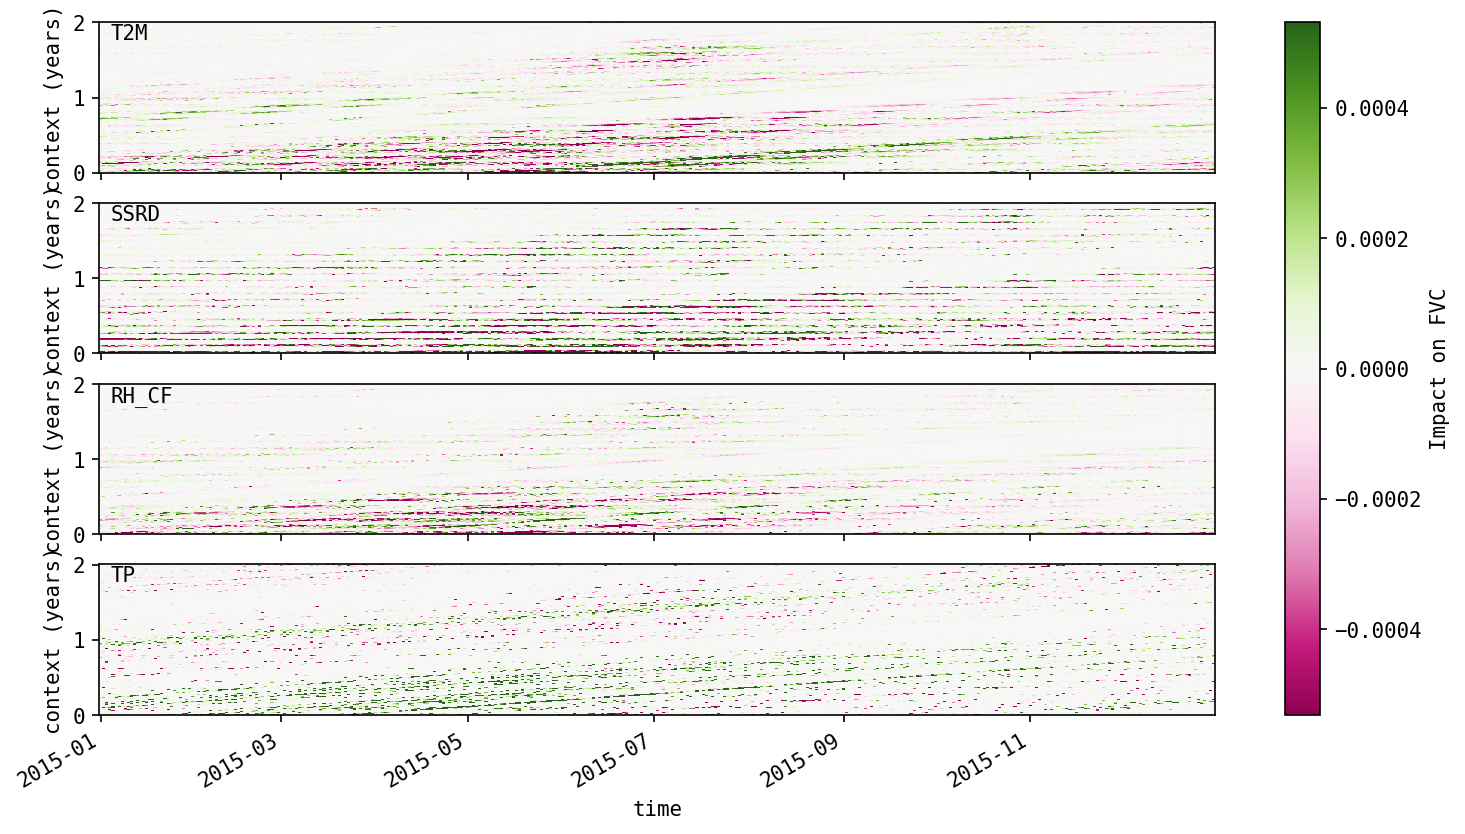

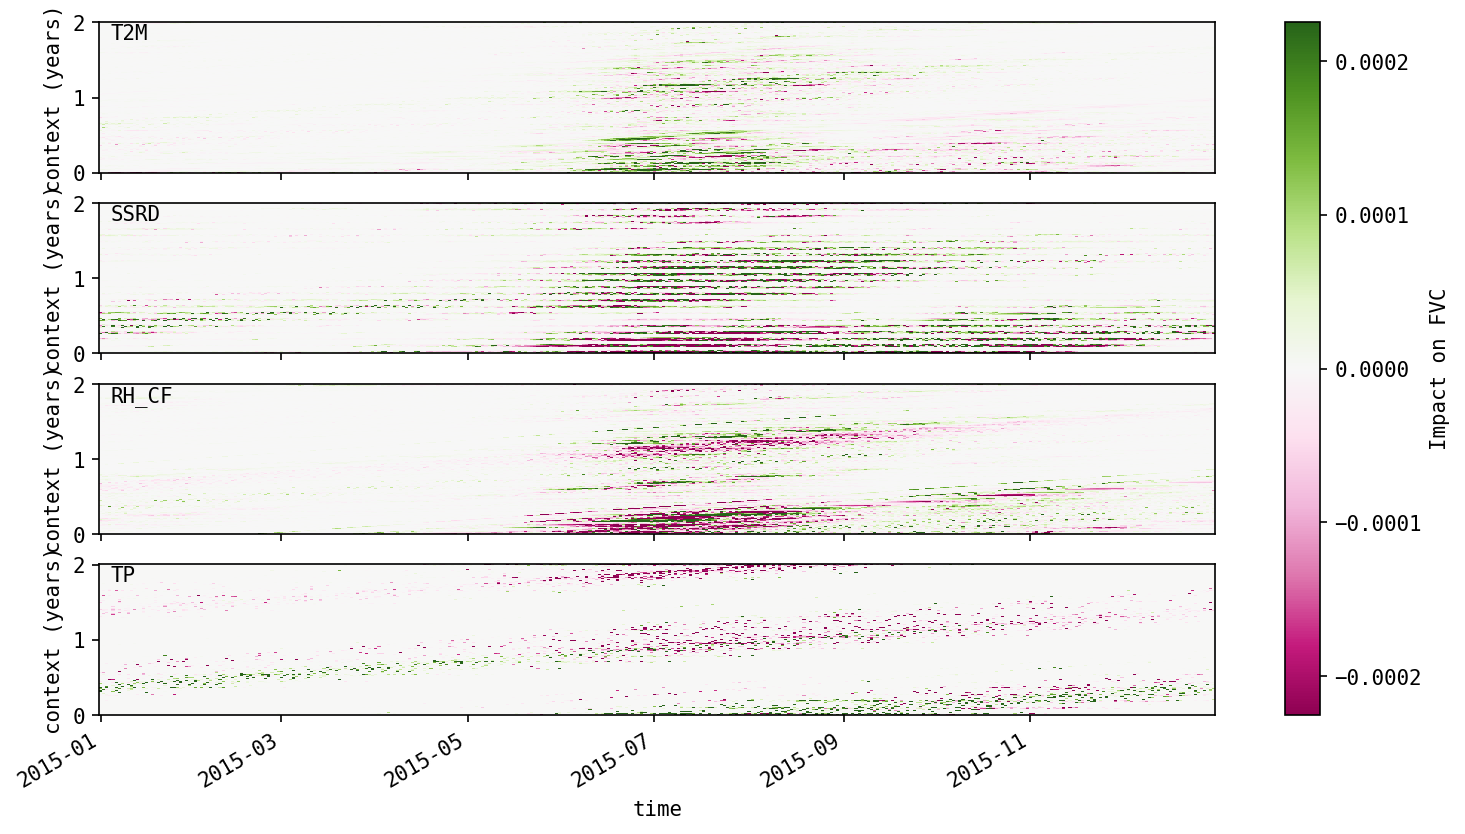

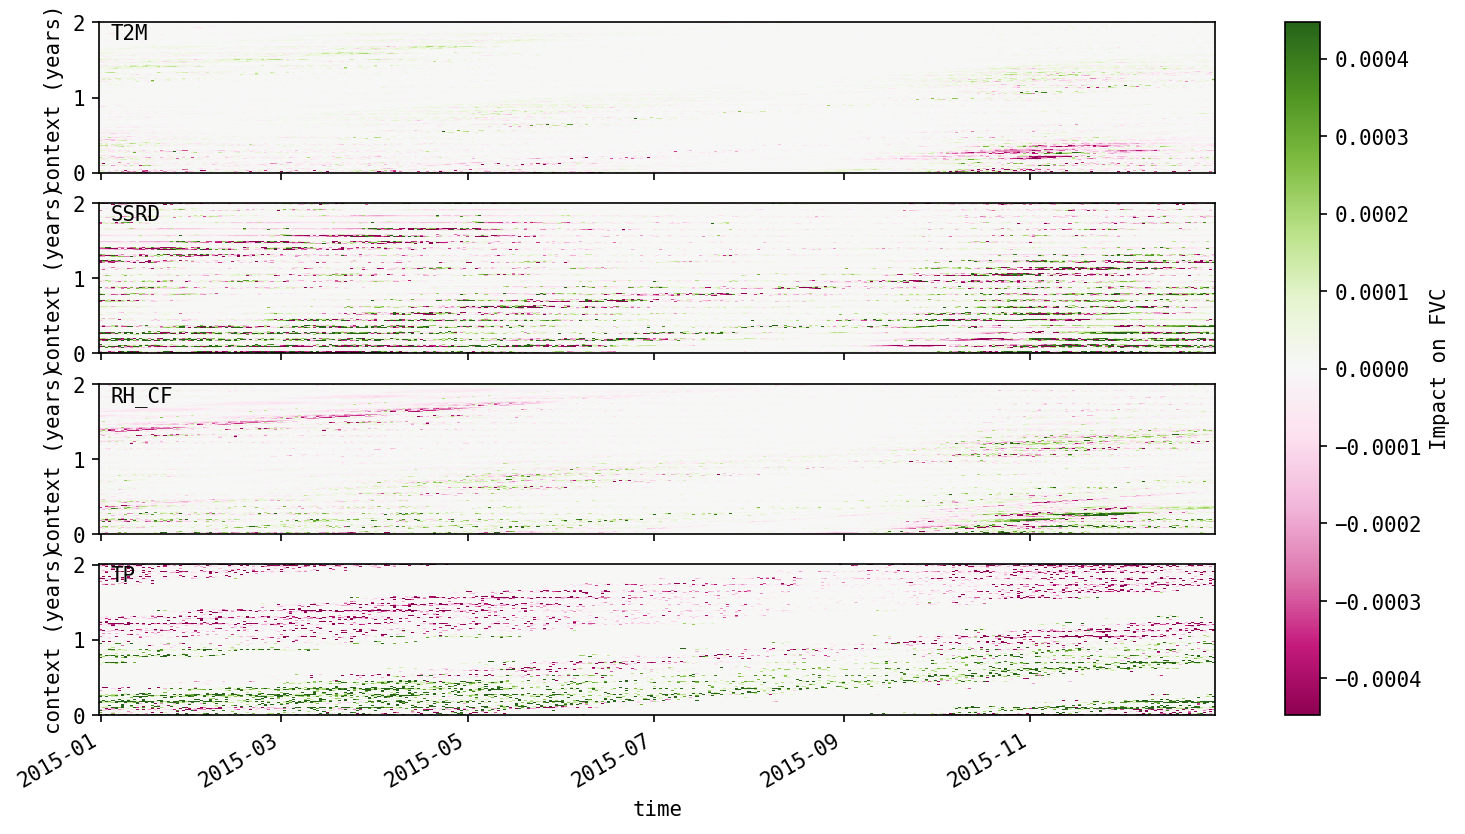

In [91]:
for lat, lon in zip(lats, lons):

    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12, 6))

    lim = np.abs(igs[dynamic_vars].sel(lat=lat, lon=lon).to_array().load().quantile([0.01, 0.99])).max().item()

    for i, var in enumerate(dynamic_vars):
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            s = stackdims(igs[var], ['context', 'hour'], 'context', False)
        ax = axes.flatten()[i]
        im = s.sel(lat=lat, lon=lon).load().T.plot(cmap='PiYG', ax=ax, add_colorbar=False, vmin=-lim, vmax=lim)
        ax.set_title('')
        if i < 3:
            ax.set_xlabel('')
        ax.invert_yaxis()
        ax.text(0.01, 0.99, var.upper(), ha='left', va='top', transform=ax.transAxes)
        ytick_pos = np.arange(0, -len(s.context), -364 * 24)
        ytick_labels = np.arange(len(ytick_pos))
        ax.set_yticks(ytick_pos, labels=ytick_labels)
        ax.set_ylabel('context (years)')

    fig.colorbar(im, ax=axes.ravel().tolist(), label='Impact on FVC')
    fig.savefig(f'../../visualization/plots/dynamic_imshow_lat{lat}_lon{lon}.png', dpi=300, bbox_inches='tight')